In [133]:
# data manipulation
import pandas as pd
import numpy as np
from datetime import timezone, timedelta, time, datetime
from math import sqrt

# stats liibs
import scipy.stats as stats
import pingouin as pg

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("seaborn-darkgrid")
rcParams['figure.figsize'] = (12,  6)
sns.set(font_scale=1.5)

# make reproducible
np.random.seed(42)

# Creating Categorical Ordered
from pandas.api.types import CategoricalDtype
month_type = CategoricalDtype(categories=['Jan', 'Feb','Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'], ordered=True)
day_type = CategoricalDtype(categories=['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# dataset
wildfire = 'https://bit.ly/3fVhoGZ'

# Portugal Districts
# Center   = ['Castelo Branco', 'Viseu', 'Guarda', 'Aveiro', 'Coimbra', 'Leiria']
# Algarve  = ['Faro']
# Alentejo = ['Évora', 'Beja', 'Portalegre', 'Santarém']
# Lisbon   = ['Lisboa', 'Setúbal']
# Northen  = ['Viana Do Castelo', 'Porto', 'Braga', 'Vila Real', 'Bragança']

North    = ['Porto', 'Vila Real']

# Six-Step Statistical Investigation Method

* Define|Ask a Research Question
* Design a study and collect Data (Step will be skipped)
* Explore the Data
* Draw inferences
* Formulate Conclusions
* Look back & ahead

## 1. Define|Ask a Research Question

### Do the Porto and Vila Real Districts have the same characteristics regarding Fire Typology, Fire Causes, Temporal Incidence (Weekday and Month), Fire Duration and Burnt Area?

### Variables to be used: 

    * Qualitative Variables (Categorical data): 
        - Tipo: wildfire type: “Florestal, Agrícola, Falso Alarme, Queimada” 
        - Distrito: Administrative areas 
        - TipoCausa: Source – “Intencional, Natural, Negligente, Desconhecida, Reacendimento, NULL” 

    * Quantitative Variables (Numerical data) 
        - DataAlerta: Communication date 
        - HoraAlerta: Communication hour 
        - DataExtinção: Extinction date 
        - HoraExtinção: Extinction hour 
        - AA_Total (pov+mato+agric) (ha): Total burned area 



## 2. Explore the Data (Data Cleaning & Filtering)

  - Remove duplicate rows
  - Remove rows where type of wildfire is "Falso Alarme"
  - Remove rows where date of Alert is greater that date of Extinction

In [44]:
# Load dataset
df = pd.read_csv(wildfire, sep=';')
df.head()

,Ano,Codigo SGIF,Codigo_ANPC,Tipo,Distrito,Concelho,Freguesia,Local,INE,x,...,Falso Alarme,Fogacho,Incendio,Agricola,Perimetro,APS,Causa,TipoCausa,Região PROF,UGF
0,2015,DM315252,2015160007544,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),160746,167814,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Alto Minho
1,2015,DM215305,2015130043758,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,130731,193731,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Tâmega
2,2015,DM415293,2015030021973,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,31323,172162,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
3,2015,DM315261,2015160007563,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),160709,171291,...,1,0,0,0,NaN,NaN,630.0,Desconhecida,Entre Douro e Minho,Alto Minho
4,2015,BL115321,2015180015874,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,180304,217299,...,0,1,0,0,NaN,NaN,630.0,Desconhecida,Beira Litoral,Dão Lafões


In [45]:
# Inspecting dataset colunms name
df.columns

Index(['Ano', 'Codigo SGIF', 'Codigo_ANPC', 'Tipo', 'Distrito', 'Concelho',
       'Freguesia', 'Local', 'INE', 'x', 'y', 'lat', 'lon', 'DataAlerta',
       'HoraAlerta', 'DataExtincao', 'HoraExtincao', 'Data1Intervencao',
       'Hora1Intervencao', 'FonteAlerta', 'NUT', 'AA_Povoamento (ha)',
       'AA_Mato (ha)', 'AA_Agricola (ha)',
       'AA_EspacosFlorestais (pov+mato)(ha)', 'AA_Total (pov+mato+agric) (ha)',
       'Reacendimentos', 'Queimada', 'Falso Alarme', 'Fogacho', 'Incendio',
       'Agricola', 'Perimetro', 'APS', 'Causa', 'TipoCausa', 'Região PROF',
       'UGF'],
      dtype='object')

In [46]:
# Inspecting dataset shape
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns. ')

The dataset has 23175 rows and 38 columns. 


In [54]:
# Inspect duplicate rows
print(f'Number of Duplicated Rows: {df.duplicated().sum()}')

Number of Duplicated Rows: 0


In [55]:
# Inspecting colunms with null values
display(df[df.columns[df.isnull().any()]].isnull().sum(axis=0))

Local                   1
DataExtincao          312
HoraExtincao          317
Data1Intervencao     1199
Hora1Intervencao     1213
FonteAlerta         23175
Perimetro           22349
APS                 22116
Causa                7013
TipoCausa            7013
Região PROF             2
UGF                     1
dtype: int64

In [56]:
# Inspecting columns datatype
df[['DataAlerta','HoraAlerta', 'DataExtincao', 'HoraExtincao']].dtypes

DataAlerta      object
HoraAlerta      object
DataExtincao    object
HoraExtincao    object
dtype: object

In [58]:
# Converting Date Columens to datetime
df['DAlert'] = df['DataAlerta'].str[:10].astype(str) + ' ' + df['HoraAlerta'].astype(str)
df['DExtiction'] = df['DataExtincao'].str[:10].astype(str) + ' ' + df['HoraExtincao'].astype(str)

df[['DAlert', 'DExtiction']] = df[['DAlert', 'DExtiction']].apply(pd.to_datetime, errors='coerce')

# Inspecting columns datatype
print(df[['DAlert', 'DExtiction']].dtypes)

# Inspecting first rows
df[['DAlert', 'DExtiction']].head(2)

DAlert        datetime64[ns]
DExtiction    datetime64[ns]
dtype: object


,DAlert,DExtiction
0,2015-03-24 17:01:00,2015-03-24 18:09:00
1,2015-03-24 17:10:00,2015-03-24 18:47:00


In [61]:
print('Number of wildfires by Type - Absolute')
display(df.Tipo.value_counts(dropna=False))

print('Number of wildfires by Type - Relative')
display(df.Tipo.value_counts(dropna=False, normalize=True))

Number of wildfires by Type - Absolute


Florestal       15464
Agrícola         4163
Falso Alarme     2925
Queimada          623
Name: Tipo, dtype: int64

Number of wildfires by Type - Relative


Florestal       0.667271
Agrícola        0.179633
Falso Alarme    0.126214
Queimada        0.026882
Name: Tipo, dtype: float64

In [80]:
# Columns for analysis
columns = ['Distrito','Tipo', 'TipoCausa', 'DAlert','DExtiction','AA_Total (pov+mato+agric) (ha)']
names   = ['District','Type', 'TypeCause', 'DateAlert', 'DateExtinction','AreaTotal']

# Filter the dataset
filtered = df[columns].query('Distrito in @North & Tipo != "Falso Alarme"')

# Reset & drop Indexes
filtered.reset_index(inplace=True, drop=True)

# Renaming columns
filtered.columns = names
filtered.head()

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal
0,Porto,Florestal,Negligente,2015-03-24 17:10:00,2015-03-24 18:47:00,"1,35"
1,Vila Real,Florestal,Negligente,2015-03-24 21:40:00,2015-03-25 05:45:00,"38,5"
2,Porto,Florestal,NaN,2015-03-25 15:30:00,2015-03-25 18:25:00,"0,05"
3,Vila Real,Florestal,Negligente,2015-03-25 16:00:00,2015-03-25 17:00:00,"0,01"
4,Vila Real,Florestal,Negligente,2015-03-25 16:40:00,2015-03-25 18:00:00,"0,02"


In [81]:
# Inspecting Type of Fire
display(filtered.Type.value_counts(normalize=True))

Florestal    0.950225
Agrícola     0.046582
Queimada     0.003193
Name: Type, dtype: float64

In [82]:
# Calculating time of fire and getting day of week

filtered['FireDuration']   = filtered.DateExtinction - filtered.DateAlert
filtered['DayAlert']       = filtered.DateAlert.dt.day_name()
filtered['Month']          = filtered.DateExtinction.dt.month_name().str[:3]
filtered['HourTotal']      = filtered.FireDuration / pd.Timedelta(1, 'h')
filtered['DayOfYear']      = filtered.DateAlert.dt.day_of_year
filtered['HourOfDay']      = filtered.DateAlert.dt.hour

# Converting datatypes
filtered['AreaTotal'] = filtered['AreaTotal'].str.replace(',', '.').astype('float')
filtered['Month'] = filtered['Month'].astype(month_type)
filtered['DayAlert'] = filtered['DayAlert'].astype(day_type)



In [83]:
# Inspecting colunms with null values
display(filtered[filtered.columns[filtered.isnull().any()]].isnull().sum(axis=0))

TypeCause         2081
DateExtinction       9
FireDuration         9
Month                9
HourTotal            9
dtype: int64

In [84]:
# Rows with null values on Date Extinction
display(filtered[filtered.Month.isnull()])

# Removing rows with null values on Date Extinction
filtered.dropna(subset=['Month'], inplace=True, axis='rows')

# Inspecting dataset
display(filtered[filtered.Month.isnull()])

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay
811,Porto,Florestal,Negligente,2015-03-06 11:37:00,NaT,3.797,NaT,Friday,NaN,NaN,65,11
843,Porto,Florestal,NaN,2015-07-20 13:08:00,NaT,2.000,NaT,Monday,NaN,NaN,201,13
846,Vila Real,Florestal,Reacendimento,2015-07-20 22:20:00,NaT,0.001,NaT,Monday,NaN,NaN,201,22
3248,Porto,Florestal,Negligente,2015-05-18 21:24:00,NaT,0.005,NaT,Monday,NaN,NaN,138,21
3323,Porto,Florestal,NaN,2015-06-27 00:05:00,NaT,0.001,NaT,Saturday,NaN,NaN,178,0
3901,Vila Real,Florestal,Negligente,2015-10-01 12:19:00,NaT,2.000,NaT,Thursday,NaN,NaN,274,12
3976,Vila Real,Florestal,Negligente,2015-09-29 13:18:00,NaT,0.050,NaT,Tuesday,NaN,NaN,272,13
4429,Porto,Florestal,NaN,2015-07-23 23:55:00,NaT,0.001,NaT,Thursday,NaN,NaN,204,23
4508,Porto,Agrícola,Desconhecida,2015-07-23 23:40:00,NaT,0.020,NaT,Thursday,NaN,NaN,204,23


,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay


In [85]:
# Inspecting new dataset shape
print(f'The dataset has {filtered.shape[0]} rows and {filtered.shape[1]} columns. ')
print(f'Filtered dataframe accounts for {round(filtered.shape[0]/df.shape[0]*100, 2)}% of source')

The dataset has 5315 rows and 12 columns. 
Filtered dataframe accounts for 22.93% of source


In [87]:
# Inspecting whether the date of Alert is greater that Extinction
display(filtered[(filtered.DateAlert > filtered.DateExtinction) == True])

# Removing rows where date of Alert is greater that Extinction
north = filtered[(filtered.DateAlert > filtered.DateExtinction) == False].copy(deep=True)
display(north[(north.DateAlert > north.DateExtinction) == True])

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay
77,Vila Real,Florestal,Intencional,2015-03-06 16:39:00,2015-03-06 00:00:00,6.00,-1 days +07:21:00,Friday,Mar,-16.650000,65,16
689,Vila Real,Florestal,Negligente,2015-05-17 11:52:00,2015-05-17 00:23:00,21.00,-1 days +12:31:00,Sunday,May,-11.483333,137,11
2917,Vila Real,Florestal,NaN,2015-08-15 20:56:00,2015-08-15 02:20:00,2.50,-1 days +05:24:00,Saturday,Aug,-18.600000,227,20
3388,Vila Real,Florestal,Negligente,2015-07-21 19:09:00,2015-07-21 02:05:00,1.50,-1 days +06:56:00,Tuesday,Jul,-17.066667,202,19
3625,Vila Real,Florestal,Desconhecida,2015-07-11 20:43:00,2015-07-11 02:30:00,0.14,-1 days +05:47:00,Saturday,Jul,-18.216667,192,20


,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay


In [88]:
north.head()

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay
0,Porto,Florestal,Negligente,2015-03-24 17:10:00,2015-03-24 18:47:00,1.35,0 days 01:37:00,Tuesday,Mar,1.616667,83,17
1,Vila Real,Florestal,Negligente,2015-03-24 21:40:00,2015-03-25 05:45:00,38.50,0 days 08:05:00,Tuesday,Mar,8.083333,83,21
2,Porto,Florestal,NaN,2015-03-25 15:30:00,2015-03-25 18:25:00,0.05,0 days 02:55:00,Wednesday,Mar,2.916667,84,15
3,Vila Real,Florestal,Negligente,2015-03-25 16:00:00,2015-03-25 17:00:00,0.01,0 days 01:00:00,Wednesday,Mar,1.000000,84,16
4,Vila Real,Florestal,Negligente,2015-03-25 16:40:00,2015-03-25 18:00:00,0.02,0 days 01:20:00,Wednesday,Mar,1.333333,84,16


In [89]:
print("TypeCause  Numbers")
display(north.TypeCause.value_counts(dropna=False, ascending=False, normalize=True))
print("Type Numbers")
display(north.Type.value_counts(dropna=False, ascending=False, normalize=True))


TypeCause  Numbers


NaN              0.391149
Negligente       0.247458
Desconhecida     0.140490
Intencional      0.114878
Reacendimento    0.103955
Natural          0.002072
Name: TypeCause, dtype: float64

Type Numbers


Florestal    0.950282
Agrícola     0.046516
Queimada     0.003202
Name: Type, dtype: float64

In [94]:
# show statistics values for all dataset
north.describe(include='all', datetime_is_numeric=True)

,District,Type,TypeCause,DateAlert,DateExtinction,AreaTotal,FireDuration,DayAlert,Month,HourTotal,DayOfYear,HourOfDay
count,5310,5310,3233,5310,5310,5310.000000,5310,5310,5310,5310.000000,5310.000000,5310.000000
unique,2,3,5,NaN,NaN,NaN,NaN,7,12,NaN,NaN,NaN
top,Porto,Florestal,Negligente,NaN,NaN,NaN,NaN,Sunday,Aug,NaN,NaN,NaN
freq,3989,5046,1314,NaN,NaN,NaN,NaN,895,1208,NaN,NaN,NaN
mean,NaN,NaN,NaN,2015-06-28 17:59:51.446327808,2015-06-28 20:05:35.898305280,1.530223,0 days 02:05:44.451977401,NaN,NaN,2.095681,179.132957,14.321846
min,NaN,NaN,NaN,2015-01-01 16:12:00,2015-01-01 17:20:00,0.000100,0 days 00:00:00,NaN,NaN,0.000000,1.000000,0.000000
25%,NaN,NaN,NaN,2015-05-19 18:14:15,2015-05-19 19:53:45,0.010000,0 days 01:01:00,NaN,NaN,1.016667,139.000000,12.000000
50%,NaN,NaN,NaN,2015-07-13 17:20:30,2015-07-13 19:35:00,0.050000,0 days 01:34:00,NaN,NaN,1.566667,194.000000,15.000000
75%,NaN,NaN,NaN,2015-08-10 18:50:45,2015-08-10 20:30:00,0.400000,0 days 02:25:45,NaN,NaN,2.429167,222.000000,18.000000
max,NaN,NaN,NaN,2015-12-27 13:55:00,2015-12-27 18:45:00,494.000000,6 days 02:58:00,NaN,NaN,146.966667,361.000000,23.000000


### Main conclusions:
  * Burned area (AreaTotal) with a mean of 1.53 ha and a median of 0.05 ha
  * Fire Duration (FireDuation) with a mean of ~ 2 hours and a median of  ~ 1.5 hours

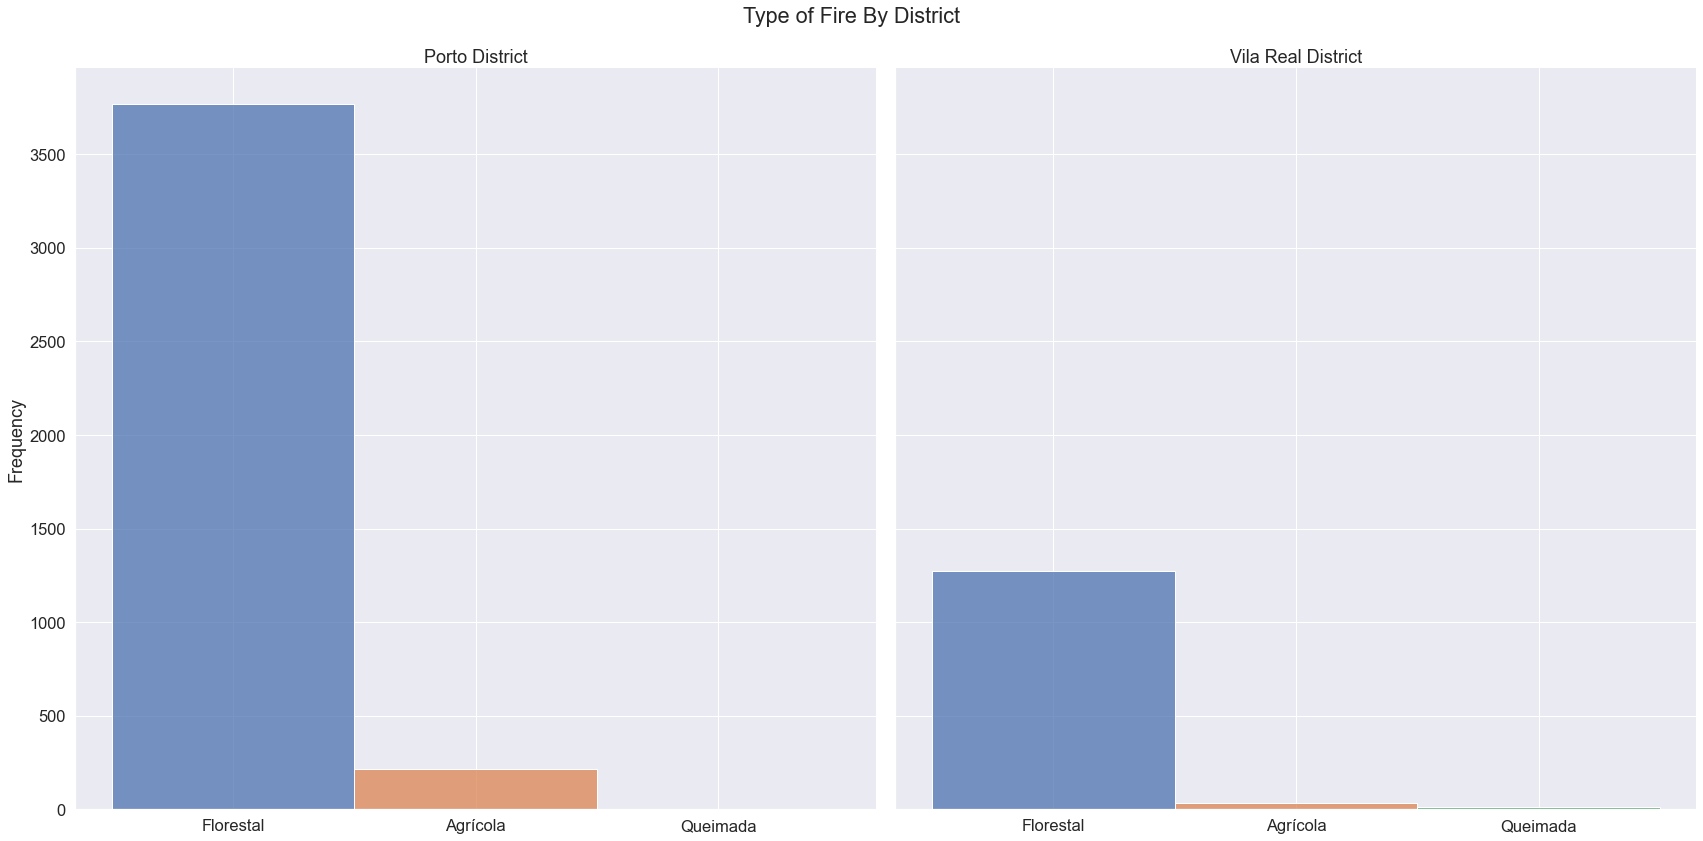

In [95]:
g = sns.FacetGrid(north, col="District", height= 12, hue="Type")
g.map_dataframe(sns.histplot, x="Type")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Type of Fire By District")
g.tight_layout();

### Main takeway

* From the Histogram analysis, both districts have the same behaviour. 
* This is a unimodal distribution with the type of fire "Florestal" being the most prevalent. By comparison, on national basis 67% of the fires are "Florestal", while for Vila Real and Porto it accouts to 97% and 95% , respectively.

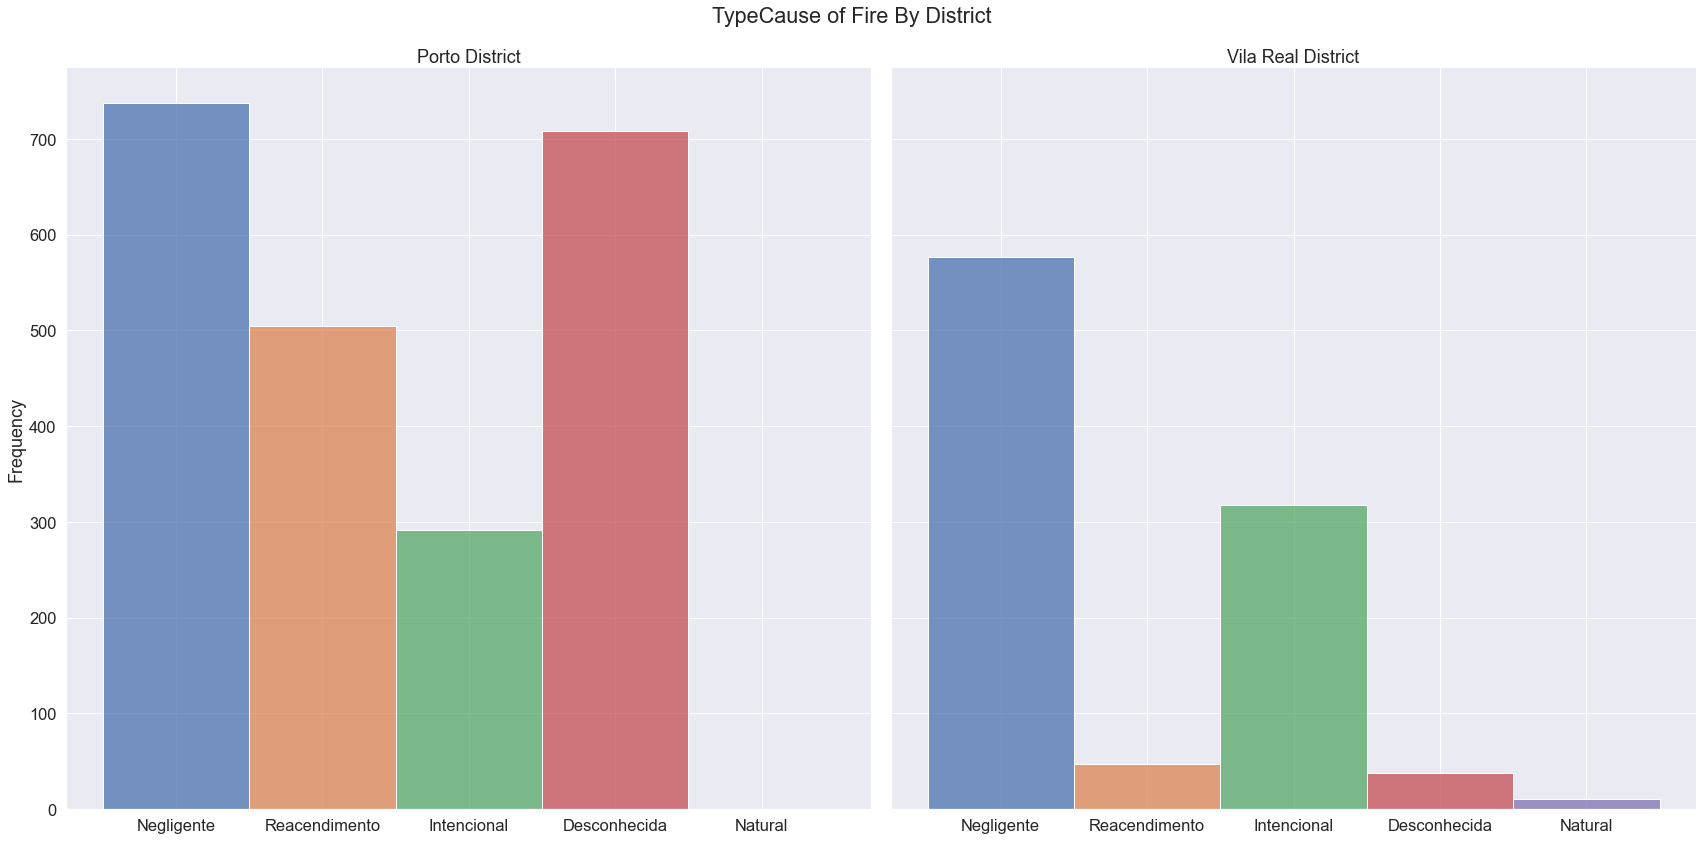

In [96]:
g = sns.FacetGrid(north, col="District", height= 12, hue="TypeCause")
g.map_dataframe(sns.histplot, x="TypeCause")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("TypeCause of Fire By District")
g.tight_layout();

### Main takeway

* From the Histogram analysis, both districts have almost the same behaviour. 
* While Porto has a bimodal distribution with "Negligente" and "Desconhecida" being the most prevalent type of causes, the distribution for Vila Real is unimodal being only "Negligente" the most prevalent cause.

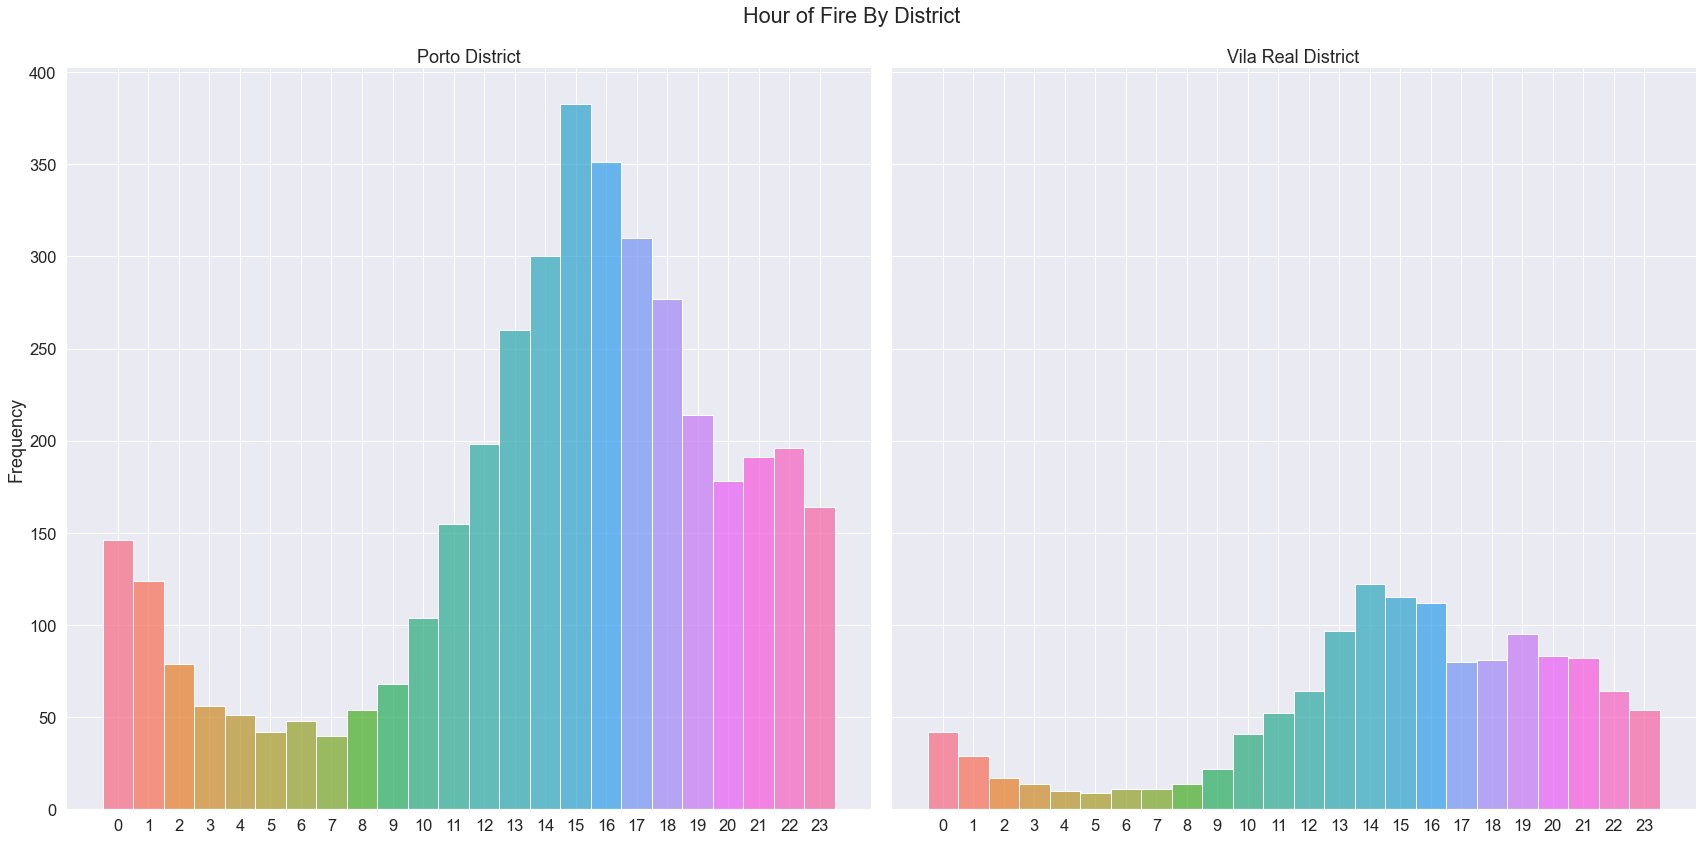

In [97]:
g = sns.FacetGrid(north, col="District", height= 12, hue="HourOfDay")
g.map_dataframe(sns.histplot, x="HourOfDay")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Hour of Fire By District")
g.set(xticks=np.arange(0,24,1))
g.set_xticklabels(np.arange(0,24,1))
g.tight_layout();

### Main takeway

* From the Histogram analysis, both districts have the same behaviour. 
* This is a bimodal distribution having one pick at 00:00 and the other at 15:00 PM.
* In terms of skewness, both distract have left skew

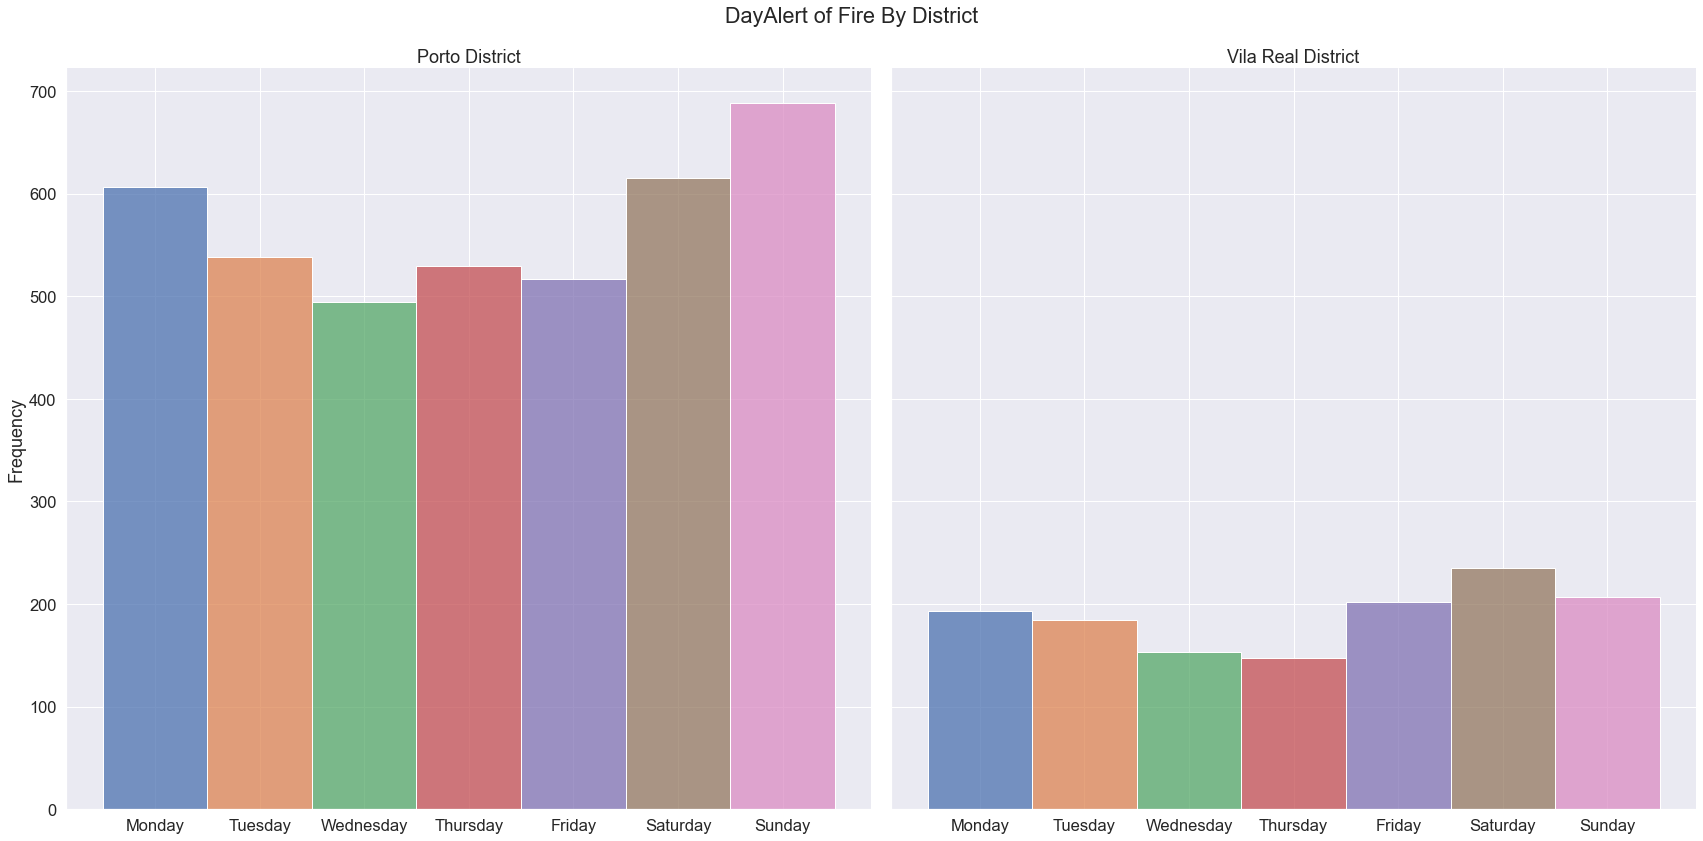

In [98]:
g = sns.FacetGrid(north, col="District", height= 12, hue="DayAlert")
g.map_dataframe(sns.histplot, x="DayAlert")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("DayAlert of Fire By District")

g.tight_layout();

### Main takeway

* From the Histogram analysis, both districts have the same behaviour. 
* This is a uniform distribution. However, the weekend has a higher frequency of alerts

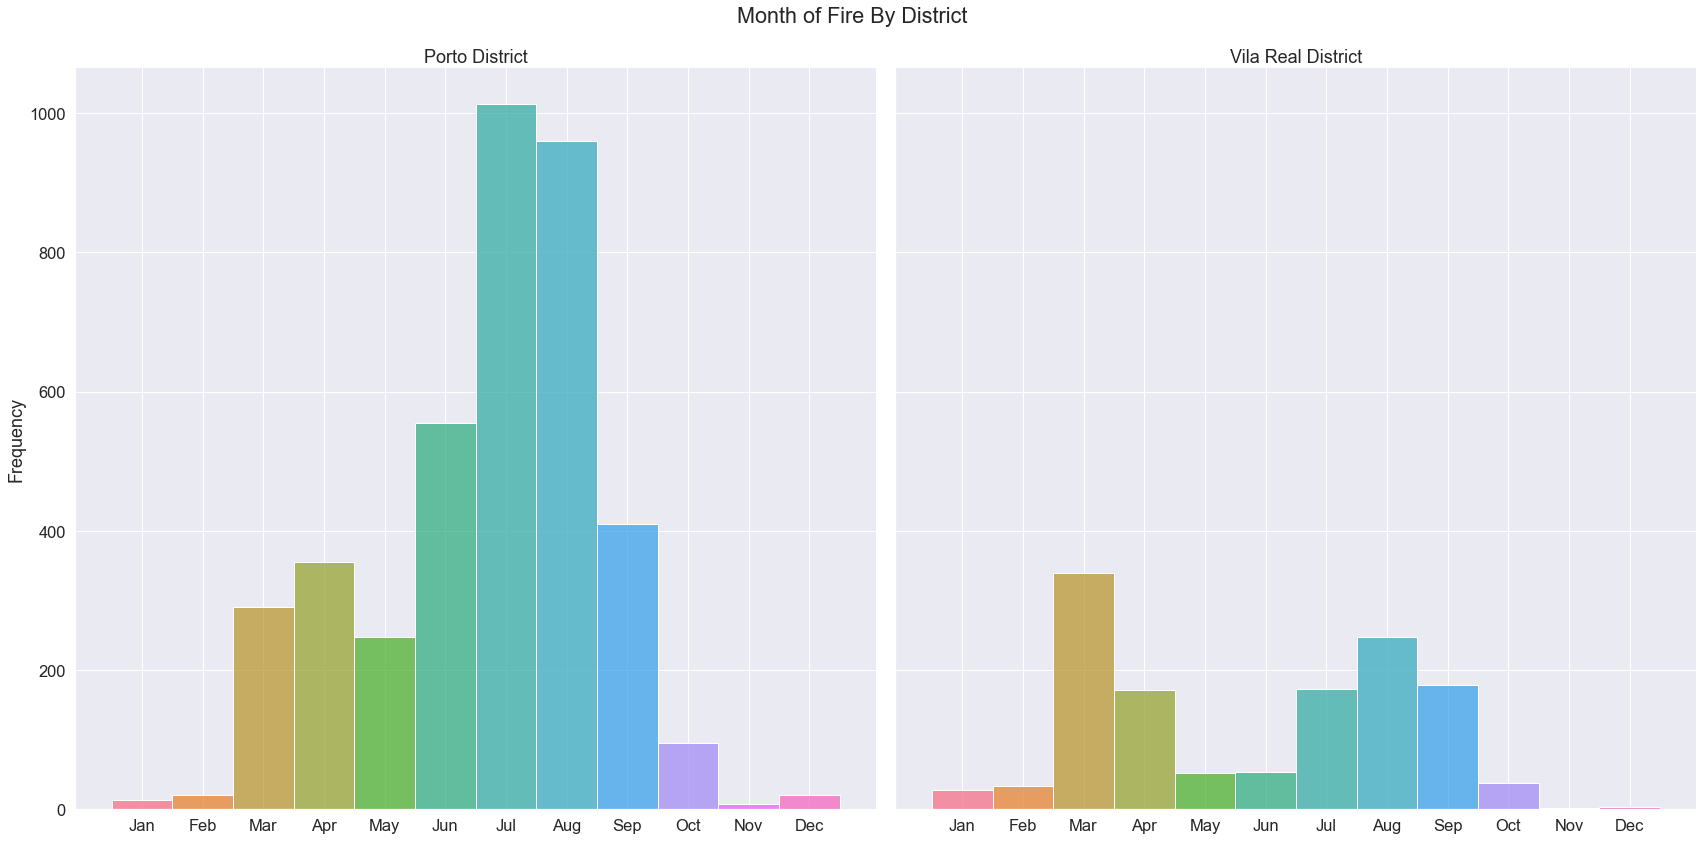

In [150]:
g = sns.FacetGrid(north, col="District", height= 12, hue="Month")
g.map_dataframe(sns.histplot, x="Month")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("Month of Fire By District")

g.tight_layout();

### Main takeway

* From the Histogram analysis, both districts have the same behaviour. 
* This is a bimodal distribution having one pick at March-April and the other at June-August
* In terms of skewness, both distract have left skew

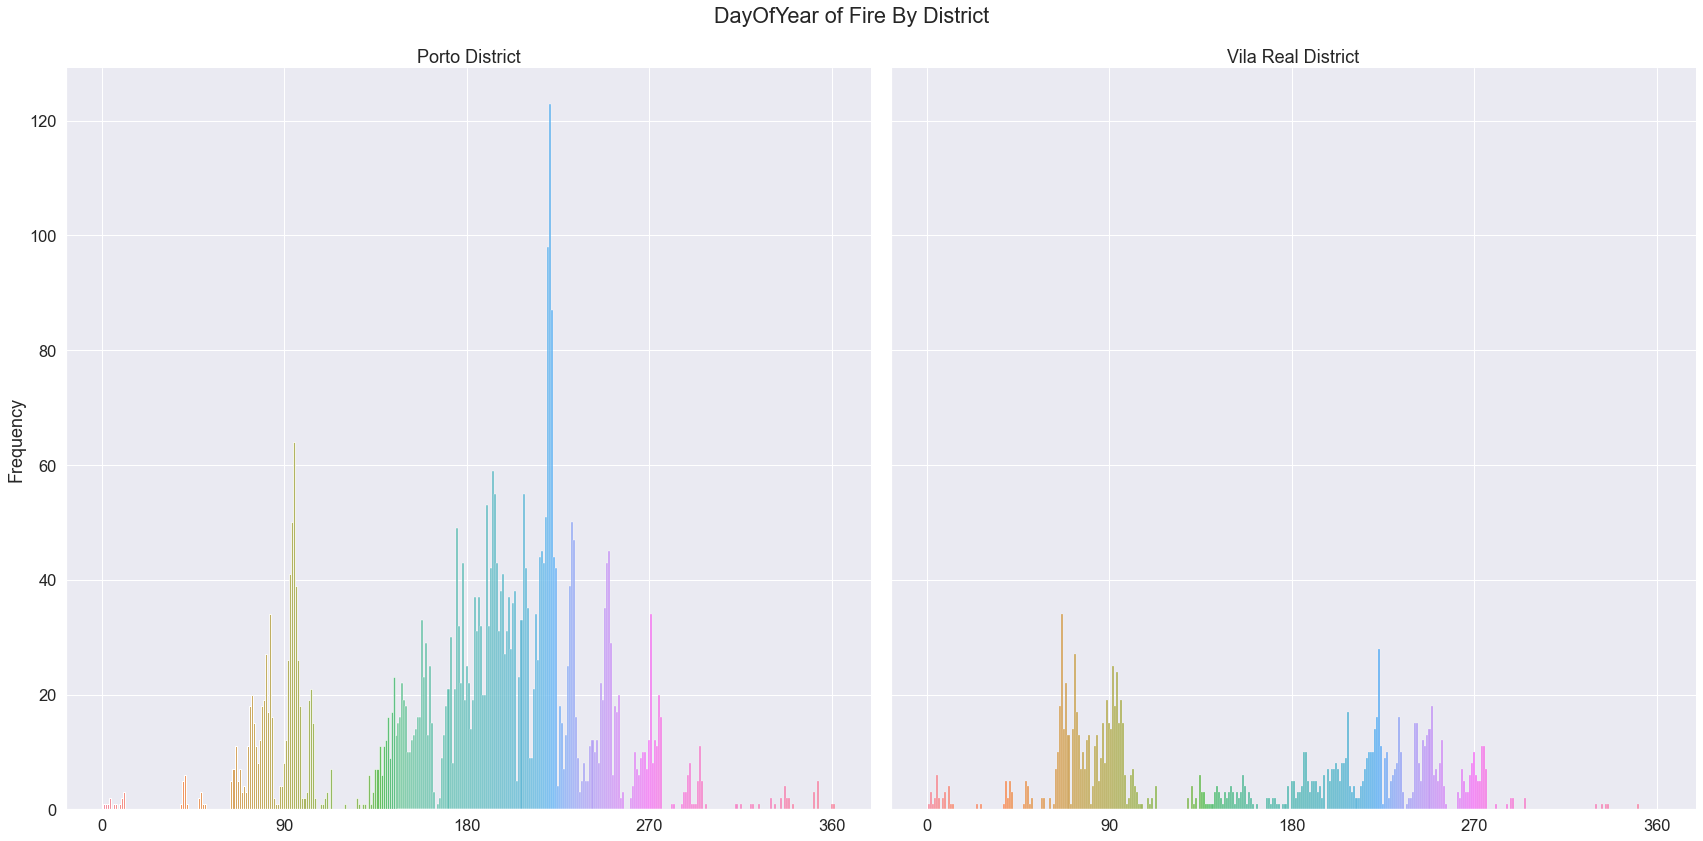

In [100]:
g = sns.FacetGrid(north, col="District", height= 12, hue="DayOfYear")
g.map_dataframe(sns.histplot, x="DayOfYear")
g.set_axis_labels("", "Frequency")
g.set_titles(col_template="{col_name} District", row_template="{row_name}")
g.fig.suptitle("DayOfYear of Fire By District")
g.set(xticks=np.arange(0,366,90))
g.set_xticklabels(np.arange(0,366,90))
g.tight_layout();

In [117]:
burnArea = north.groupby('District')['AreaTotal'].agg('sum')

display(burnArea)

District
Porto        2540.0338
Vila Real    5585.4480
Name: AreaTotal, dtype: float64

In [118]:
burnAreaType = north.query('AreaTotal > 0').groupby(['District','Type'])['AreaTotal'].sum().reset_index(name='totalArea')
burnAreaType

,District,Type,totalArea
0,Porto,Agrícola,18.4295
1,Porto,Florestal,2521.5383
2,Porto,Queimada,0.0660
3,Vila Real,Agrícola,8.6800
4,Vila Real,Florestal,5573.1420
5,Vila Real,Queimada,3.6260


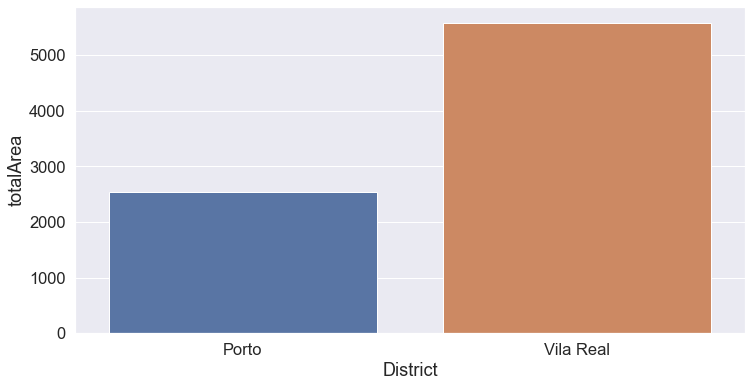

In [119]:
burnAreaT = north.query('AreaTotal > 0').groupby('District')['AreaTotal'].sum().reset_index(name='totalArea')

sns.barplot(x="District", y='totalArea', data=burnAreaT);

### Main takeway

* 1...
* 2...

In [120]:
# Group by stats for burned area group by distrito
north.groupby(by="District")['Type'].agg('count')

District
Porto        3989
Vila Real    1321
Name: Type, dtype: int64

In [121]:
# group by stats for burned area group by distrito
north.groupby(by="District")['AreaTotal'].describe()

,count,mean,std,min,25%,50%,75%,max
District,,,,,,,,
Porto,3989.0,0.636760,4.943955,0.0001,0.01,0.05,0.2,188.4
Vila Real,1321.0,4.228197,23.534165,0.0001,0.02,0.50,2.0,494.0


### Main Take Aways - Burned Area
  - Porto has a mean burned area of 0.64ha with a median of 0.05ha 
  - Vila Real has a mean burned area of 4.22 ha with a median of 0.50ha 
  - While Vila Real has a burned area 4 times larger than Porto although Porto has the triple of fire incidentes of Vila Real

In [122]:
# group by stats for Fire Duration in hours group by distrito
north.groupby(by="District")['HourTotal'].describe()

,count,mean,std,min,25%,50%,75%,max
District,,,,,,,,
Porto,3989.0,1.829001,2.743295,0.000000,1.000000,1.50,2.233333,146.966667
Vila Real,1321.0,2.900971,4.470066,0.166667,1.166667,1.95,3.183333,96.316667


### Main Take Aways - Fire Duration:
  - Porto has a mean fire duration of 1.83 hours with a median of 1.5 hours
  - Vila Real has a mean fires duration of 2.9 hours with a median of 1.95 hours
  - Besides the previous results, it seems like theres no significant difference in Fire Durations in both locations.

# 4. Draw Inferences

## Question: The mean Burned Area in Vila Real is significantly greater than in Porto?

In [130]:
porto = north[north['District'] == 'Porto']
vila  = north[north['District'] == 'Vila Real']

Aporto = porto.AreaTotal.values
Avila  = vila.AreaTotal.values
print('Porto variance: ',round(np.var(Aporto),2))
print('Vila Real variance: ',round(np.var(Avila),2))

print('Variance ratio: ',
    round(max(np.var(Aporto), np.var(Avila)) / min(np.var(Aporto), np.var(Avila)),2))

Porto variance:  24.44
Vila Real variance:  553.44
Variance ratio:  22.65


In [131]:
#perform two sample t-test with equal variances
stats.ttest_ind(a=Aporto, b=Avila, equal_var=True)

Ttest_indResult(statistic=-9.055359233595215, pvalue=1.8765695032567563e-19)

Note: 
	
	Here, the ratio is bigger than 4:1. We will carry out the T-Test with outher method.
	
	

### Method 2: Two-Sample T-Test with Pingouin

Pingouin is a statistical-type package project that is based on Pandas and NumPy. Pingouin provides a wide range of features. The package is used to conduct the T-Test but also for computing the degree of freedoms, Bayers factor, etc.

Firstly, let’s create the sample data. We are creating two arrays and now let’s perform two sample T-Test. For this purpose, we have ttest() function in the pingouin package of Python.

In [134]:
#perform two sample t-test with equal variances
result = pg.ttest(Aporto, Avila, correction=True)

# Print the result
print(result)

               T          dof alternative         p-val           CI95%  \
T-test -5.506433  1358.768711   two-sided  4.373289e-08  [-4.87, -2.31]   

         cohen-d       BF10  power  
T-test  0.287455  1.243e+05    1.0  


## Question --- Are the percentage of burned forest wildfires are equal in both districts

In [144]:
#Inference Qualitaty


FPorto  = porto[porto.Type == 'Florestal'].shape[0]
FVila   = vila[vila.Type   == 'Florestal'].shape[0]
Forrest = north[north.Type == 'Florestal'].shape[0]

NPorto   = porto[porto.Type != 'Florestal'].shape[0]
NVila    = vila[vila.Type   != 'Florestal'].shape[0]
NForrest = north[north.Type != 'Florestal'].shape[0]


nPorto = FPorto + NPorto
nVReal = FVila + NVila
nTotal = Forrest + NForrest

header = ['is_florestal', 'Porto', 'Vila', 'Total']
data = [
  [True, FPorto, FVila, Forrest],
  [False, NPorto, NVila, NForrest],
  ['Total', nPorto, nVReal, nTotal],
]

forrest_df = pd.DataFrame(columns=header, data=data)
display(forrest_df)

,is_florestal,Porto,Vila,Total
0,True,3771,1275,5046
1,False,218,46,264
2,Total,3989,1321,5310


# Testing the null hypothesis

H0: Percentage of burned forest wildfires are equal in both districts

\begin{equation}
\hat{p} Porto - \hat{p} Vila Real = 0
\end{equation}

HA: Percentage of burned forest wildfires are larger in the Porto than in the Vila Real

\begin{equation}
\hat{p} Porto - \hat{p} Vila Real > 0
\end{equation}


𝑝̂ 0=# 𝑜𝑓 𝑠𝑢𝑐𝑐𝑒𝑠𝑠𝑒𝑠1+# 𝑜𝑓 𝑠𝑢𝑐𝑐𝑒𝑠𝑠𝑒𝑠2𝑛1+𝑛2/ n1+n2


In [146]:
# The pooled estimate of a proportion is presented in slide 22 of chp6_2p.pdf from the references
pTotal = Forrest/ nTotal
print(f'The pooled estimate of percentage of forest fires (Both Districts) is {round(pTotal*100,1)}%')

The pooled estimate of percentage of forest fires (Both Districts) is 95.0%


**Compute** the test statistics **texto em negrito**

𝑍=(𝑝̂ Porto−𝑝̂ VReal)/(SQRoot(𝑝̂0(1−𝑝̂0)(1/𝑛Porto+1/𝑛VReal))

In [147]:
# Calculating the proportions:

pPorto = FPorto / nPorto
pVReal = FVila / nVReal


print(f'{round(pPorto*100,1)}% of the fires in the Porto are Forest Wildfires')
print(f'{round(pVReal*100,1)}% of the fires in the Vila Real are Forest Wildfires')

94.5% of the fires in the Porto are Forest Wildfires
96.5% of the fires in the Vila Real are Forest Wildfires


In [148]:
# The test statistics of a difference of proportions is presented in slide 24 of chp6_2p.pdf from the references

Z = (pPorto - pVReal )/(sqrt(pTotal*(1-pTotal)*(1/nPorto + 1/nVReal)))

print(f'The test statistic of the difference of proportions is {Z}')

The test statistic of the difference of proportions is -2.873677565894065


In [149]:
#Compute the p-value 

print(f'p-value = 2 * P(Z < {round(Z,6)}):')

p_value = stats.norm.cdf(Z)*2 #twosided

display(p_value)

p-value = 2 * P(Z < -2.873678):


0.004057229369836075